In [104]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [105]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ardat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
from sklearn.preprocessing import LabelEncoder
train_classification_df = pd.read_csv("train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)

label_encoder = LabelEncoder()

# Fit and transform the 'category' column
train_classification_df["encoded_category"] = label_encoder.fit_transform(train_classification_df["category"])

# Create mapping of usernames to unified (lowercase) categories
#username2_category = train_classification_df.set_index("user_id")["category"].to_dict()

username2_category = train_classification_df.set_index("user_id").to_dict()["encoded_category"]

In [107]:
import gzip
with open("training-dataset.jsonl", "rb") as f_in:
    with gzip.open("training-dataset.jsonl.gz", "wb") as f_out:
        f_out.writelines(f_in)


In [108]:
train_data_path = "training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [109]:
missing_profiles = [
    username for username in username2posts_train.keys()
    if username not in username2profile_train
]
print("Missing profiles:", missing_profiles)


Missing profiles: []


In [110]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re



def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s@#]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []

for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)


vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=7500)


# fit the vectorizer
vectorizer.fit(corpus)


# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]


test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

In [112]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_text(text: str):
    # Lowercase the text (casefold handles Turkish-specific letters)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation, but keep hashtags (#) and emojis
    # Unicode emoji range is retained along with hashtags
    text = re.sub(r'[^a-zçğıöşü0-9\s#\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

corpus = []
train_usernames = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)

    # Aggregating the posts, biography, and full name per user
    cleaned_text = []
    bio_user = username2profile_train[username].get("biography", "") or ""

    # Preprocess biography and prepend identifier
    bio_user = preprocess_text(bio_user)

    if bio_user != "":
        cleaned_text.append(bio_user)

    # Preprocess captions and prepend identifier
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_text.append(post_caption)

    # Combine all fields with a separator (e.g., "\n")
    user_text = "\n".join(cleaned_text)
    corpus.append(user_text)

# Initialize TF-IDF vectorizer
vectorizer2 = TfidfVectorizer(stop_words=turkish_stopwords, max_features=8000)

# Fit the vectorizer
vectorizer2.fit(corpus)

# Transform the data into vectors
x_train_vec = vectorizer2.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]

# Process the test data similarly
test_usernames = []
test_corpus = []

for username, posts in username2posts_test.items():
    test_usernames.append(username)

    cleaned_text = []
    bio_user = username2profile_test[username].get("biography", "") or ""

    bio_user = preprocess_text(bio_user)

    if bio_user != "":
        cleaned_text.append(bio_user)

    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_text.append(post_caption)

    # Combine all fields with a separator (e.g., "\n")
    user_text = "\n".join(cleaned_text)
    test_corpus.append(user_text)

# Transform the test data (no fitting)
x_test = vectorizer2.transform(test_corpus)
#y_test = [username2_category.get(uname, "NA") for uname in test_usernames]


In [131]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_text(text: str):
    # Lowercase the text (casefold handles Turkish-specific letters)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation, but keep hashtags (#) and emojis
    # Unicode emoji range is retained along with hashtags
    text = re.sub(r'[^a-zçğıöşü0-9\s#\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

corpus = []
train_usernames = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)

    # Aggregating the posts, biography, and full name per user
    cleaned_text = []
    bio_user = username2profile_train[username].get("biography", "") or ""

    # Preprocess biography and prepend identifier
    bio_user = preprocess_text(bio_user)

    if bio_user != "":
        cleaned_text.append(bio_user)

    # Preprocess captions and prepend identifier
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_text.append(post_caption)

    # Combine all fields with a separator (e.g., "\n")
    user_text = "\n".join(cleaned_text)
    corpus.append(user_text)

# Initialize TF-IDF vectorizer
vectorizer2 = TfidfVectorizer(stop_words=turkish_stopwords, max_features=7500)

# Fit the vectorizer
vectorizer2.fit(corpus)

# Transform the data into vectors
x_train_vec = vectorizer2.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]

# Process the test data similarly
test_usernames = []
test_corpus = []

for username, posts in username2posts_test.items():
    test_usernames.append(username)

    cleaned_text = []
    bio_user = username2profile_test[username].get("biography", "") or ""

    bio_user = preprocess_text(bio_user)

    if bio_user != "":
        cleaned_text.append(bio_user)

    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_text.append(post_caption)

    # Combine all fields with a separator (e.g., "\n")
    user_text = "\n".join(cleaned_text)
    test_corpus.append(user_text)

# Transform the test data (no fitting)
x_test = vectorizer2.transform(test_corpus)
#y_test = [username2_category.get(uname, "NA") for uname in test_usernames]


In [132]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [133]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['ab', 'abd', 'abdulkadir', ..., 'şıklık', 'şıklığı', 'şımartın'],
      dtype=object)

In [134]:
df_tfidf = pd.DataFrame(x_train_vec.toarray(), columns=feature_names)
df_tfidf.head(2)

,ab,abd,abdulkadir,abdullah,abi,abiye,abone,about,abs,academicistanbul,...,şölen,şöleni,şöyle,şükranla,şükranlarımızı,şükür,şık,şıklık,şıklığı,şımartın
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046079,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [135]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

,ab,abd,abdulkadir,abdullah,abi,abiye,abone,about,abs,academicistanbul,...,şölen,şöleni,şöyle,şükranla,şükranlarımızı,şükür,şık,şıklık,şıklığı,şımartın
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.046003,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [136]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def get_avg_like_count(username):
    def calculate_avg(posts: list):
        total = 0
        count = 0
        for post in posts:
            like_count = post.get("like_count", 0)
            if like_count is None:
                like_count = 0
            total += like_count
            count += 1

        return total / count if count > 0 else 0

    # Check if the username exists in training or testing data
    if username in username2posts_train:
        return calculate_avg(username2posts_train[username])
    elif username in username2posts_test:
        return calculate_avg(username2posts_test[username])
    else:
        print(f"No data available for {username}")
        return -1

# Initialize an empty list to store rows
data = []
# Loop through usernames in the training set
for username in train_usernames:
    # Get profile info for the user
    profile = username2profile_train[username]

    average_like = get_avg_like_count(username)
    # Extract profile-related features
    profile_info = {
        #"username": username,
        "follower_count": profile.get("follower_count", 0) or 0,
        "following_count": profile.get("following_count", 0) or 0,
        #"highlight_reel_count": profile.get("highlight_reel_count", 0) or 0,
        #"post_count": profile.get("post_count", 0) or 0,
        "is_verified": profile.get("is_verified", False),
        "is_business_account": profile.get("is_business_account", False),
        "is_private": profile.get("is_private", False),
        #"category_name": profile.get("category_name", "Unknown"),
        "average_like": average_like
    }
    #bio = profile.get("biography", "") or ""
    #if bio:
    #    bio = preprocess_text(bio)
    #    if bio:  # Ensure the processed caption is not empty
    #        bio_corpus.append(bio)

    data.append(profile_info)

# Convert the list of dictionaries into a DataFrame
df_train_pro = pd.DataFrame(data)

# label encoder
#label_encoder = LabelEncoder()
#df_train_pro["category_name"] = label_encoder.fit_transform(df_train_pro['category_name'])

# Fit and transform the TF-IDF vectorizer
#vectorizer_bio = TfidfVectorizer(stop_words=turkish_stopwords, max_features=500)
#x_bio_tfidf = vectorizer_bio.fit_transform(bio_corpus)
#tfidf_df_bio = pd.DataFrame(x_bio_tfidf.toarray(), columns=vectorizer_bio.get_feature_names_out())
#print(f"TF-IDF matrix shape: {x_bio_tfidf.shape}")

# Convert binary columns (True/False) to 0/1
binary_columns = ['is_verified', 'is_private', 'is_business_account']
for col in binary_columns:
    df_train_pro[col] = df_train_pro[col].astype(int)

df_combined = pd.concat([df_train_pro.reset_index(drop=True), df_tfidf.reset_index(drop=True)], axis=1)
df_combined.head()

,follower_count,following_count,is_verified,is_business_account,is_private,average_like,ab,abd,abdulkadir,abdullah,...,şölen,şöleni,şöyle,şükranla,şükranlarımızı,şükür,şık,şıklık,şıklığı,şımartın
0,1167,192,0,1,0,11.542857,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.046003,0.0,0.0,0.0
1,11997,17,0,1,0,31.514286,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,2321,454,0,1,0,233.885714,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.038769,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,13647,29,1,1,0,361.342857,0.0,0.0,0.0,0.04432,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,7917,11,1,1,0,72.800000,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [137]:
# Compute the correlation matrix
correlation_matrix = df_train_pro.corr()

# Print the correlation matrix
correlation_matrix

,follower_count,following_count,is_verified,is_business_account,is_private,average_like
follower_count,1.000000,-0.003915,0.082114,-0.054047,-0.000672,0.107474
following_count,-0.003915,1.000000,0.091103,-0.156497,-0.006674,0.029898
is_verified,0.082114,0.091103,1.000000,-0.279183,0.034614,0.269230
is_business_account,-0.054047,-0.156497,-0.279183,1.000000,-0.030593,-0.189937
is_private,-0.000672,-0.006674,0.034614,-0.030593,1.000000,-0.003056
average_like,0.107474,0.029898,0.269230,-0.189937,-0.003056,1.000000


In [138]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_train_pro)

# Step 2: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components (adjust as needed)
principal_components = pca.fit_transform(scaled_data)

# Step 3: Create a DataFrame with principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [139]:
df_pca_tfidf = pd.concat([pca_df.reset_index(drop=True), df_tfidf.reset_index(drop=True)], axis=1)
df_pca_tfidf.head()

,PC1,PC2,ab,abd,abdulkadir,abdullah,abi,abiye,abone,about,...,şölen,şöleni,şöyle,şükranla,şükranlarımızı,şükür,şık,şıklık,şıklığı,şımartın
0,-0.833127,-0.250891,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.046003,0.0,0.0,0.0
1,-0.880793,-0.377352,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,-0.757440,-0.065504,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.038769,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.487451,-0.450489,0.0,0.0,0.0,0.04432,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.478052,-0.460303,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


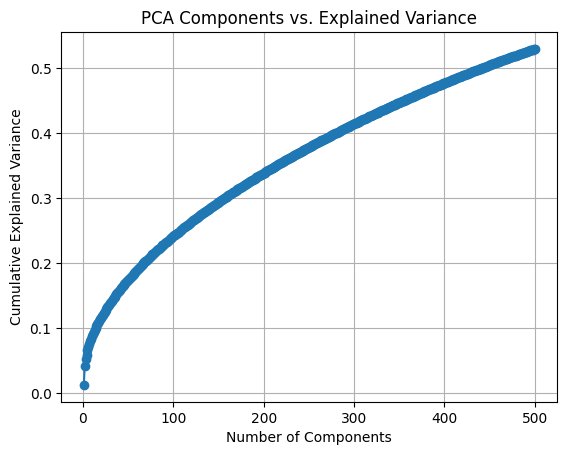

In [140]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Set the number of components to a valid value
n_components = min(3000, 500)  # Use the smaller of 3000 features or 500 components
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit the Truncated SVD
svd.fit(df_tfidf)

# Plot cumulative explained variance
cumulative_variance = svd.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Components vs. Explained Variance')
plt.grid(True)
plt.show()


In [141]:
# Step 2: Apply Truncated SVD
svd = TruncatedSVD(n_components=1000, random_state=42)  # Reduce to 1000 components
reduced_matrix = svd.fit_transform(df_tfidf)
# Convert to DataFrame
columns = [f'PC_TFIDF{i+1}' for i in range(reduced_matrix.shape[1])]  # Create column names like PC1, PC2, ...
reduced_df = pd.DataFrame(reduced_matrix, columns=columns)

In [142]:
df_pca_tfidf2 = pd.concat([pca_df.reset_index(drop=True), reduced_df.reset_index(drop=True)], axis=1)
df_pca_tfidf2.head()

,PC1,PC2,PC_TFIDF1,PC_TFIDF2,PC_TFIDF3,PC_TFIDF4,PC_TFIDF5,PC_TFIDF6,PC_TFIDF7,PC_TFIDF8,...,PC_TFIDF991,PC_TFIDF992,PC_TFIDF993,PC_TFIDF994,PC_TFIDF995,PC_TFIDF996,PC_TFIDF997,PC_TFIDF998,PC_TFIDF999,PC_TFIDF1000
0,-0.833127,-0.250891,0.242881,-0.133512,-0.067585,0.097690,-0.078565,-0.028958,0.086562,0.007845,...,0.032680,-0.017686,-0.019648,-0.008684,0.010919,-0.020975,0.017606,-0.022047,0.015104,0.000223
1,-0.880793,-0.377352,0.211314,-0.143605,0.134954,0.077109,0.154289,0.089197,-0.042001,-0.016427,...,0.020500,-0.031853,-0.026830,-0.006150,-0.005810,0.011936,0.000007,-0.011027,-0.018034,-0.009029
2,-0.757440,-0.065504,0.246878,-0.158294,0.048489,-0.041849,-0.058544,-0.019607,-0.009950,0.023067,...,-0.001182,-0.018641,-0.002366,-0.001401,0.005700,-0.000781,-0.024998,-0.039688,0.006460,-0.027939
3,0.487451,-0.450489,0.178003,-0.141418,-0.410259,-0.179712,0.165892,0.026959,-0.093659,-0.059742,...,-0.005738,-0.013787,-0.025254,-0.015024,-0.029886,-0.016220,0.020307,-0.018112,-0.024515,0.000329
4,0.478052,-0.460303,0.087808,-0.058710,-0.009133,0.031556,-0.023699,-0.011765,-0.025348,-0.008443,...,0.064956,0.012468,-0.033319,0.021902,0.014126,-0.012645,0.023343,-0.023838,0.012099,-0.061980


In [143]:
df_combined.head(2)

,follower_count,following_count,is_verified,is_business_account,is_private,average_like,ab,abd,abdulkadir,abdullah,...,şölen,şöleni,şöyle,şükranla,şükranlarımızı,şükür,şık,şıklık,şıklığı,şımartın
0,1167,192,0,1,0,11.542857,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.046003,0.0,0.0,0.0
1,11997,17,0,1,0,31.514286,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [144]:
from sklearn.model_selection import train_test_split
X = df_tfidf
y = y_train
x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [145]:
x_train.head()

,ab,abd,abdulkadir,abdullah,abi,abiye,abone,about,abs,academicistanbul,...,şölen,şöleni,şöyle,şükranla,şükranlarımızı,şükür,şık,şıklık,şıklığı,şımartın
2638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051177,0.0,0.0
1736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [146]:
x_val.shape

(549, 7500)

In [ ]:
from sklearn.model_selection import cross_val_score
#NEW NEW BESTTT
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Define Stacking Classifier
stacking_model2 = StackingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=200, subsample=0.8, random_state=42)),
        ('lr_l1', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)),
        ('lr_l2', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)),
        ('svm', SVC(C=50, class_weight='balanced', degree=2, gamma=0.01, kernel='rbf', random_state=42) ),
        ('mlp', MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate='adaptive', learning_rate_init=0.001, solver='adam', random_state=42)) # Neural Network
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False, criterion='gini', max_depth=50, min_samples_leaf=2, min_samples_split=10)
)

# Use cross-validation to get a stable performance estimate
scores = cross_val_score(stacking_model2, X, y, cv=5)
print(f"Mean Accuracy: {scores.mean():.4f}")


c:\Users\ardat\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
#@title Test Data


# let's take a look at the first 5 lines of the file
test_data_path = "test-classification-round2.dat"
!head -n 5 "$test_data_path"

print("*****")

test_unames = []
with open(test_data_path, "rt") as fh:
  for line in fh:
    test_unames.append(line.strip())

print(test_unames[:5])

In [ ]:
x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)




In [ ]:
df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
df_test.shape

In [ ]:
test_pred = stacking_model.predict(df_test)
original_categories = label_encoder.inverse_transform(test_pred)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = original_categories[index]

In [ ]:
print("Length of test_unames:", len(test_unames))
print("Length of test_pred:", len(test_pred))
print("Length of original_categories:", len(original_categories))


In [ ]:
with open("prediction-classification-round2.json", "w") as of:
  json.dump(output, of, indent=4)